In [11]:
#imports
import time
import datetime
from itertools import product
import operator

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score

import altair as alt
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [2]:
#global vars
NUM_QUANTILES = 10

In [ ]:
#get dataset
dataBunch = datasets.load_breast_cancer(return_X_y=False)
data_to_use = {"data": dataBunch.data[:,:10],
               "target": dataBunch.target,
               "feature_names": dataBunch.feature_names[:10],
               "feature_locs": {x:i for i,x in enumerate(dataBunch.feature_names[:10])}
              } #make it easy to change out data

In [ ]:
dataCervicalCancer = pd.read_csv("data/cervical_cancer.csv")
target = dataCervicalCancer.Biopsy
dataCervicalCancer = dataCervicalCancer.drop(["Person", "Biopsy"],axis=1)
data_to_use = {"data": dataCervicalCancer.values,
               "target": target,
               "feature_names": dataCervicalCancer.columns,
               "feature_locs": {x:i for i,x in enumerate(dataCervicalCancer.columns)}   
              }

In [3]:
def load_bike_dataset():
    def _datestr_to_timestamp(s):
        return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())

    data = pd.read_csv('data/bike.csv')
    data['dteday'] = data['dteday'].apply(_datestr_to_timestamp)
    data = pd.get_dummies(data, prefix=["weathersit"], columns=["weathersit"], drop_first=False)
    
    #de-normalize data to produce human-readable features.
    #Original range info from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
    data["hum"] = data["hum"].apply(lambda x: x*100.)
    data["windspeed"] = data["windspeed"].apply(lambda x: x*67.)
    #convert Celsius to Fahrenheit
    data["temp"] = data["temp"].apply(lambda x: (x*47. - 8)*9/5 +32)
    data["atemp"] = data["atemp"].apply(lambda x: (x*66. - 16)*9/5 + 32)
    
    #rename features to make them interpretable for novice users
    feature_names_dict = {"yr":"First or Second Year", 
                              "season":"Season", 
                              "hr":"Hour of Day", 
                              "workingday":"Work Day",
                              "weathersit_2":"Misty Weather",
                              "weathersit_3":"Light Precipitation",
                              "weathersit_4":"Heavy Precipitation",
                              "temp":"Temperature (F)",
                              "atemp":"Feels Like (F)",
                              "hum":"Humidity",
                              "windspeed":"Wind Speed"}
    data= data.rename(mapper=feature_names_dict,axis=1) 
    features = feature_names_dict.values()

    X = data[features]
    y = data['cnt']

    return X, y, features

In [39]:
dataBike, targetBike, featuresBike = load_bike_dataset()
data_to_use = {"data": dataBike.values,
               "target": targetBike,
               "feature_names": featuresBike,
               "feature_locs": {x:i for i,x in enumerate(featuresBike)}   
              }
target_type="Regression"

In [27]:
#build classifier to explain
classifier = GradientBoostingRegressor(n_estimators=300, max_depth=2)
classifier.fit(data_to_use["data"], data_to_use["target"])
predictions = classifier.predict(data_to_use["data"])
print r2_score(data_to_use["target"], predictions)

0.8035072512016352


In [58]:
#generate data structure for pairwise charts
feature_pairs = {key: {"map":None,
                       "bolShow": True,
                       "dropReason": None,
                       "predicates":[]}\
                 for key in set([tuple(sorted(t)) for t in product(data_to_use["feature_names"], repeat=2)])}
feature_ranges = {}
for feature in data_to_use["feature_names"]:
    loc = data_to_use["feature_locs"][feature]
    quantiles = []
    if np.unique(data_to_use["data"][:,loc]).shape[0] < 5 or type(data_to_use["data"][0,loc]) is str:
        print feature + " is of type string"
        quantiles = np.unique(data_to_use["data"][:,loc])
    else:
        quantiles = np.around(np.unique(np.quantile(a=data_to_use["data"][:,loc], q=np.linspace(0, 1, NUM_QUANTILES))),4)
    feature_ranges[feature] = quantiles

def get_quantile_matrix(feat1, feat2):
    h = list(feature_ranges[feat1])*len(feature_ranges[feat2])
    v = [item for item in list(feature_ranges[feat2])\
         for i in range(len(feature_ranges[feat1]))]                        
    return h,v 

def get_leaf_value(model, node_position):
    if target_type=="Classification":
        return model.tree_.value[node_position][0][1]/\
                    (model.tree_.value[node_position][0][1] + model.tree_.value[node_position][0][0])
    else:
        return model.tree_.value[node_position]
    
for key, value in feature_pairs.iteritems():
    h, v = get_quantile_matrix(key[0], key[1])
    value["map"]=np.array([{key[0]:x, key[1]:y}\
                           for x,y in zip(h,v)])\
    .reshape(len(feature_ranges[key[0]]), len(feature_ranges[key[1]]))

for modelT in classifier.estimators_:
    if target_type == "Regression":
        model = modelT[0]
    else:
        model = modelT
    feature_ids = {i:{"number":x, "name":data_to_use["feature_names"][x]}\
                      for i,x in enumerate(list(model.tree_.feature)) if x>=0} #-2 means leaf node
    
    #need to refactor this part to condense code and prepare for handling higher-depth trees
    
    #for 1-layer trees
    if model.tree_.feature[1] <0:
        feature_pair_key = tuple(sorted([feature_ids[0]["name"], feature_ids[0]["name"]]))
        decision_func_dict = {
            "feature_name": feature_ids[0]["name"],
            "threshold": model.tree_.threshold[0],
            "operator": operator.le,
            "prob_le": get_leaf_value(model,1),
            "prob_gt": get_leaf_value(model,2)
        }       
        #build the predictive function used in the decision tree
        def dt_predicate(data_case, decision_func_dict=decision_func_dict):
            if decision_func_dict["operator"](\
                                                data_case[decision_func_dict["feature_name"]],\
                                                decision_func_dict["threshold"]\
                                               ):
                return decision_func_dict["prob_le"]
            else:
                return decision_func_dict["prob_gt"]        
    else:
        for node_position in [1,4]: #positions for left and right nodes at layer 2
            if node_position in feature_ids:
                feature_pair_key = tuple(sorted([feature_ids[0]["name"], feature_ids[node_position]["name"]]))
                #get the decision rules
                decision_func_dict = {
                    "feature_name_1": feature_ids[0]["name"],
                    "threshold_1": model.tree_.threshold[0],

                    "operator_1": operator.le if node_position == 1 else operator.gt,

                    "feature_name_2": feature_ids[node_position]["name"],
                    "threshold_2": model.tree_.threshold[node_position],

                    "operator_2": operator.le,

                    "prob_le": get_leaf_value(model,node_position+1),

                    "prob_gt": get_leaf_value(model,node_position+2)
                }
                #build the predictive function used in the decision tree
                def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                    if decision_func_dict["operator_1"](\
                                                        data_case[decision_func_dict["feature_name_1"]],\
                                                        decision_func_dict["threshold_1"]\
                                                       ):
                        if decision_func_dict["operator_2"](\
                                                            data_case[decision_func_dict["feature_name_2"]],\
                                                            decision_func_dict["threshold_2"]\
                                                           ):
                            return decision_func_dict["prob_le"]
                        else:
                            return decision_func_dict["prob_gt"]
                    else:
                        return 0.
            
            else: #asymmetric tree, this is a leaf node
                feature_pair_key = tuple(sorted([feature_ids[0]["name"], feature_ids[0]["name"]]))
                decision_func_dict = {
                    "feature_name": feature_ids[0]["name"],
                    "threshold": model.tree_.threshold[0],
                    "operator": operator.le if node_position == 1 else operator.gt,
                    
                    "prob_le": 1. if node_position == 1 else 0.,
                    
                    "prob_gt": 0. if node_position == 1 else 1.,
                }       
                #build the predictive function used in the decision tree
                def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                    if decision_func_dict["operator"](\
                                                        data_case[decision_func_dict["feature_name"]],\
                                                        decision_func_dict["threshold"]\
                                                       ):
                        return decision_func_dict["prob_le"]
                    else:
                        return decision_func_dict["prob_gt"]                  

        feature_pairs[feature_pair_key]["predicates"].append(dt_predicate)

Light Precipitation is of type string
Misty Weather is of type string
Heavy Precipitation is of type string
First or Second Year is of type string
Work Day is of type string
Season is of type string


In [60]:
#now calculate output array for each feature pair
for key, value in feature_pairs.iteritems():
    arrs = []
    for predicate in value["predicates"]:
        f = np.vectorize(predicate)
        arrs.append(f(value["map"]))
    if len(arrs) > 0:
        #details of vote aggreggation method for random forest
        #hpairttps://stats.stackexchange.com/questions/127077/random-forest-probabilistic-prediction-vs-majority-vote
        value["output"] = np.sum(np.stack(arrs, axis=-1), axis=-1)
    else:
        value["output"] = None

In [61]:
for key, value in feature_pairs.iteritems():
    h,v = get_quantile_matrix(key[0], key[1])
    value["H_Indices"] = h
    value["V_Indices"] = v
    value["Votes"] = value["output"].ravel() if value["output"] is not None else None

In [62]:
offset = 0
for key, value in feature_pairs.iteritems(): 
    if value["Votes"] is None:
        print "no predictors found: " + str(key)
        value["bolShow"] = False
        value["dropReason"] = "No Predictors"
    else:
        srs = pd.Series(value["Votes"])
        if srs.apply(lambda x: x==0.).all():
            print "all zeroes: " + str(key)
            value["bolShow"] = False
            value["dropReason"] = "All Zeroes"
        elif abs(srs.std()/srs.mean()) < 0.1:
            print "low std: " + str(key)
            offset += srs.mean()
            value["bolShow"] = False
            value["dropReason"] = "Low Variance"
        elif srs.max() < (1. if target_type=="Classification" else np.mean(data_to_use["target"])/10.):
            print "low impact: " + str(key)
            offset += srs.mean()
            value["bolShow"] = False
            value["dropReason"] = "Low Impact"
        else:
            #build dataframe for chart
            value["chart_df"] = pd.DataFrame(dict((x, value[x]) for x in ["H_Indices", "V_Indices", "Votes"]))
print offset

low impact: ('Hour of Day', 'Wind Speed')
no predictors found: ('First or Second Year', 'Work Day')
no predictors found: ('Misty Weather', 'Work Day')
low impact: ('Humidity', 'Work Day')
no predictors found: ('Season', 'Work Day')
no predictors found: ('Feels Like (F)', 'Temperature (F)')
no predictors found: ('Light Precipitation', 'Work Day')
low impact: ('Feels Like (F)', 'Work Day')
no predictors found: ('Heavy Precipitation', 'Hour of Day')
no predictors found: ('Feels Like (F)', 'Light Precipitation')
low impact: ('Misty Weather', 'Wind Speed')
no predictors found: ('Light Precipitation', 'Misty Weather')
no predictors found: ('Misty Weather', 'Misty Weather')
no predictors found: ('Feels Like (F)', 'Misty Weather')
no predictors found: ('Heavy Precipitation', 'Temperature (F)')
no predictors found: ('Heavy Precipitation', 'Wind Speed')
no predictors found: ('Heavy Precipitation', 'Work Day')
low impact: ('Hour of Day', 'Humidity')
no predictors found: ('First or Second Year', '

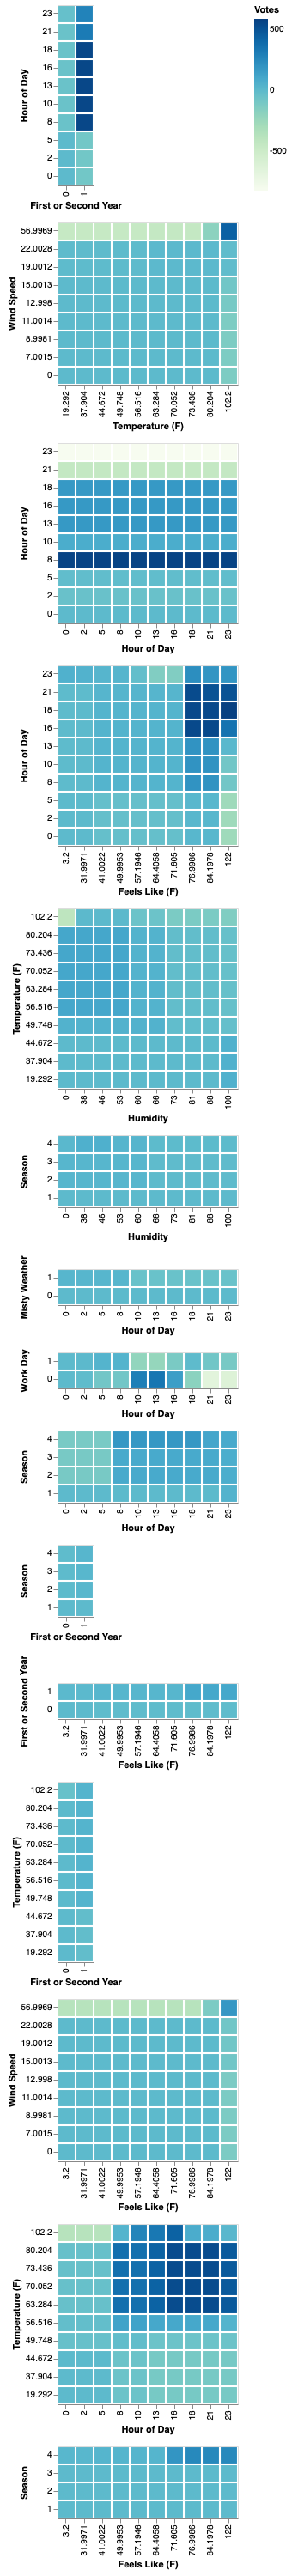

In [63]:
charts = []
for key, value in feature_pairs.iteritems():
    if value["bolShow"]:
        x_encoding = alt.X(field="H_Indices",\
                           type="ordinal", sort="ascending",
                           axis=alt.Axis(title=key[0]))
        y_encoding = alt.Y(field="V_Indices",\
                           type="ordinal", sort="descending",
                           axis=alt.Axis(title=key[1]))

        color_encoding = alt.Color(field= "Votes",
                                   type="quantitative",
                                   scale=alt.Scale(scheme="greenblue"),
                                   legend=alt.Legend(title="Votes"))
        charts.append(alt.Chart(\
                                data=value["chart_df"])\
                      .mark_rect()\
                      .encode(x=x_encoding, y=y_encoding, color=color_encoding))
alt.vconcat(*charts)

In [66]:
feature_pairs[("Humidity", "Season")]["Votes"]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       24.26120625, 24.26120625, 24.26120625, 24.26120625, 24.26120625,
       -8.48435088, -8.48435088, -8.48435088, -8.48435088, -8.48435088,
       24.26120625, 24.26120625, 24.26120625, 24.26120625, 24.26120625,
       -8.48435088, -8.48435088, -8.48435088, -8.48435088, -8.48435088,
       10.1497448 , 57.88919809, 57.88919809, 29.69041162, 29.69041162,
       -3.05514551, -3.05514551, -3.05514551, -3.05514551, -3.05514551])